Предсказание вероятности дефолта банковского клиента
====================================================
## Bank credit scoring
SkillFactory DST Project

<img src="https://www.nfcc.org/wp-content/uploads/2020/09/bigstock-Credit-Score-Concept-Business-384487778-768x477.jpg">

# Что сделано

#### Цель данного учебного Data Science проекта
 * посторить модель машинного обучения на имеющихся реальных данных
 * достичь наилучших показателей по соответствующим метрикам качества модели

#### Достигнутые результаты:

**Метрики базовой обработки и базовой модели:**

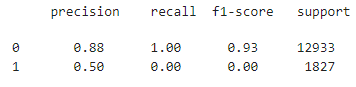

**Метрики после проведенной работы (максимальные):**

Confusion Matrix

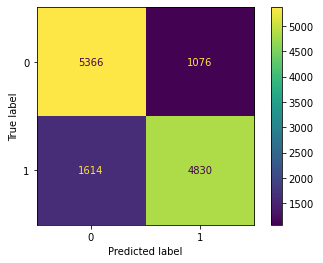

Classification Report

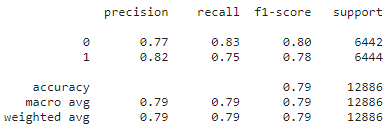

Roc Curve

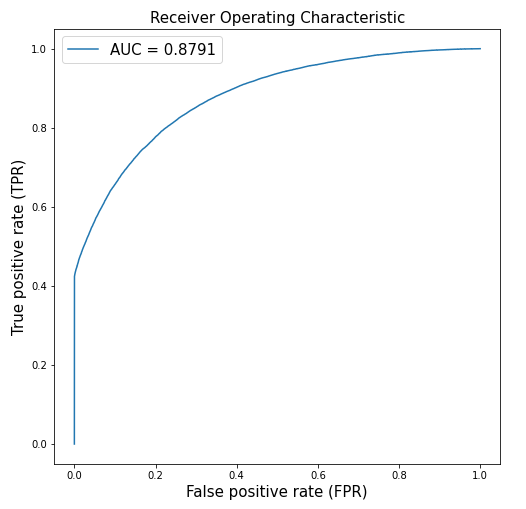

Cross Validation Metrics

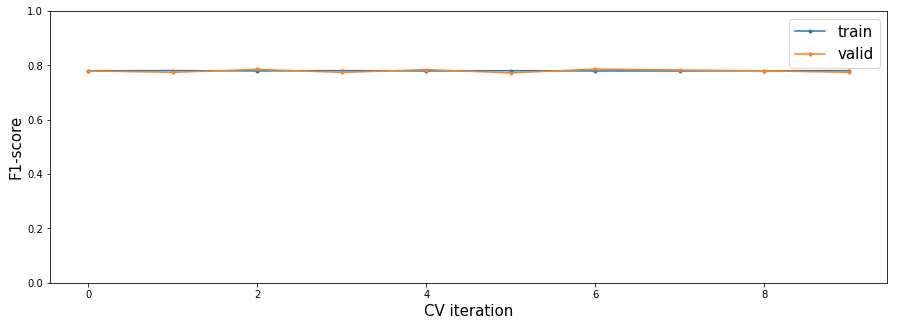

> **Это свидетельствует:**
> * о точности предстказания как возможного дефлота клиента, так и не-дефолта
> * что эта точность в среднем равна 79%
> * что пере/недо-обучения нет (показала кросс-валидация)


#### Что сделано:
> * отсеивание коррелирующих и менее значимых признаков
> * логарифмизация и нормализация численных данных
> * полиноминальные признаки (жаль, они неинтрпретируемы и могут быть отключены в финальной версии)
> * балансирование тестовой выборки
> * подбор гиперпараметров модели

### Немного аналитики

#### Интересные наблюдения из анализа датасета:
  * Один из наиболее значимых признаков -- рейтинг БКИ (score_bki)
> признаки (из всех), которые наиболее заметно меняются вместе с ним : 
> * decline_app_cnt 
> * bki_request_cnt
> * education_ACD
> * car_type
 
* Медиана возраста (age) дефолтных клиентов банка чуть ниже
 > молодые больше рискуют при меньшем опыте

* Количество отклоненных заявок (decline_app_cnt): 
 >  * значения сосредоточены у ноля
 >  * Банк отклоняет большинство рискованных заявок
 >  * 7% клиентов без отклоненных заявок оказываются дефолтными
 
* Количество запросов кредитных историй (bki_request_cnt) у дефолтных скорее отлично от 0
 > им есть о чем беспокоиться
 
* Доход (income) дефолтных ожидаемо ниже
 
 

#### Коэффициенты модели 

> Увеличение значения каждого признака на 1 (или положительное значение у бинарного) увеличивает вероятность дефолта клиента на значение 'coef'

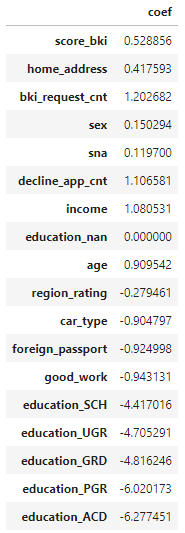

Оглавление
=================
**(структура работы)**

- [Основная часть работы](#Основная-часть-работы)
    + [Подготовка среды и загрузка датасета](#Подготовка-среды-и-загрузка-датасета)

  * [Первый взгляд на данные](#Первый-взгляд-на-данные)
    + [Названия признаков и их смысл:](#Названия-признаков-и-их-смысл:)
      - [Общая первичная обработка датасета](#Общая-первичная-обработка-датасета)

  * [Обзорный анализ](#Обзорный-анализ)
    + [Целевая переменная и отношения с ней](#Целевая-переменная-и-отношения-с-ней)
    + [Смотрим на числовые переменные](#Смотрим-на-числовые-переменные)
    + [Смотрим на категориальные переменные](#Смотрим-на-категориальные-переменные)

  * [Обработка признаков](#Обработка-признаков)

  * [Деление и модель](#Деление-и-модель)
    + [Лучший вариант модели](#Лучший-вариант-модели)
    + [Разглядываем коэффициенты модели](#Разглядываем-коэффициенты-модели)
    + [Кросс-валидация: проверяем на переобучение](#Кросс-валидация:-проверяем-на-переобучение)


	
- [Submission](#submission)

- [Приложение: отчет о датасете от pandas_profiling](#Приложение:-pandas_profiling)

[к ОГЛАВЛЕНИЮ](#Оглавление)
# Основная часть работы

### Подготовка среды и загрузка датасета

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as  sns # for visualization
from matplotlib import pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
DATA_DIR = '/kaggle/input/sf-scoring/'
#DATA_DIR = '.' #Для локальной работы
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

[к ОГЛАВЛЕНИЮ](#Оглавление)
## Первый взгляд на данные

### Названия признаков и их смысл:
    
    client_id - идентификатор клиента
    education - уровень образования
    sex - пол заемщика
    age - возраст заемщика
    car - флаг наличия автомобиля
    car_type - флаг автомобиля иномарки
    decline_app_cnt - количество отказанных прошлых заявок
    good_work - флаг наличия “хорошей” работы
    bki_request_cnt - количество запросов в БКИ
    home_address - категоризатор домашнего адреса
    work_address - категоризатор рабочего адреса
    income - доход заемщика
    foreign_passport - наличие загранпаспорта
    sna - связь заемщика с клиентами банка
    first_time - давность наличия информации о заемщике
    score_bki - скоринговый балл по данным из БКИ
    region_rating - рейтинг региона
    app_date - дата подачи заявки
    default - флаг дефолта по кредиту

In [3]:
# Размеры выборок: Тренировочной, Тестовой и файла Submission
df_train.shape, df_test.shape, sample_submission.shape

In [4]:
# Видим, что часть признаков (формат object) требует изучения и обработки
df_train.info()

In [5]:
# Значения признаков также разняться
df_train.sample(2)

#### Общая первичная обработка датасета
> необходимая (в том числе) для обзорного анализа

In [6]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [72]:
# Для удобства сгруппируем признаки в три категории по типу их обработки (категориальные, бинарные и числовые)

num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [8]:
# Наибольшее количество уникальных значений -- у признаков 'client_id' и 'score_bki'.
# --> Выборка весьма индивидуализирована по Рейтингу клиента в БКИ.
# --> Ожидаем сильного влияния 'score_bki' на целевую переменную

data.nunique(dropna=False)

In [9]:
# Признаки с id клиента и датой подачи заявки будем считать бесполезными и удалим их
data.drop(['client_id','app_date',], axis = 1, inplace=True)

### Пропуски

In [10]:
# Ищем...
data.isna().sum()

In [11]:
# Пропуски присутствуют только в 'education'. 
# Их совсем мало
data.isna().sum()[2] / data.shape[0]

In [12]:
# Заполним эти пропуски 'SCH' -- самым частым значением
data['education'].fillna(data.education.mode()[0],inplace=True)

In [13]:
# Проверяем -- всё теперь красиво 🌹 🌼
data.education.value_counts(dropna=False)

In [14]:
# Развернем заблаговременно категориальный признак 'education', а потом посмотрим на значимость каждой категории
# Также обновим переменную с названиями категориальных признаков (data.education.unique())

data = pd.get_dummies(data, columns=['education'], dummy_na=True)
cat_cols = ['education_GRD', 'education_SCH', 'education_UGR', 'education_PGR', 'education_ACD', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']


[к ОГЛАВЛЕНИЮ](#Оглавление)
## Обзорный анализ

### Целевая переменная и отношения с ней

In [15]:
# Распределение целевой переменной.
# Клиентов с дефолтом у банка значительно меньше, чем с дефолтом. 
# Это для банка хорошо, но для модели -- плоховато. 
# Ожидаем перекос предсказаний в базовом варианте обработки!

data['default'].value_counts(ascending=True).plot(kind='barh')

### Смотрим на числовые переменные 
> какие из них могут быть особо полезными и неполезными 

#### Корреляции числовых переменных 

In [16]:
# Смотрим на числовые переменные, какие из них могут быть неполезными для работы модели.
# --> Корреляции между ними слабые, можно брать всё!
# (логарифмированные и не-логарифмированные не отличаются, доказательства -- за кадром)

sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1,annot=True, cmap='YlOrBr')


#### Значимость числовых переменных 

In [17]:
# Посмотрим на значимость числовых переменных для целевой
# Ожидаемо, данные из БКИ и кол-во отказов -- самые важные.
# Неважное пока оставляем.

from sklearn.feature_selection import f_classif

imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#### Посмотрим как отличаются значения числовых переменных для дефолтных и для не-дефолтных клиентов
> возьмем двадцатку самых встречающихся значений

**Интересные наблюдения:**
 * Медиана возраста (age) дефолтных чуть ниже
 > молодые больше рискуют при меньшем опыте

 * Количество отклоненных заявок (decline_app_cnt): 
 >  * значения сосредоточены у ноля
 >  * Банк отклоняет большинство рискованных заявок
 >  * 7% клиентов без отклоненных заявок оказываются дефолтными
 
 * Количество запросов кредитных историй (bki_request_cnt) у дефолтных скорее отлично от 0
 > им есть о чем беспокоиться
 
 * Доход (income) дефолтных ожидаемо ниже
 

In [18]:
def get_boxplot(df, column):
    '''Функция для построения boxplot'''
    fig, ax = plt.subplots(figsize=(3, 6))
    sns.boxplot(x='default', y=column,
                data=df,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    

In [19]:
for column in num_cols:
    get_boxplot(data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts(normalize=True).index[:20])], column)
   

In [20]:
# 7% клиентов без отклоненных заявок оказываются дефолтными (не оплачивают кретит)
data[data['default'] == 1]['decline_app_cnt'].value_counts(normalize=True)[0]

[к ОГЛАВЛЕНИЮ](#Оглавление)
### Смотрим на категориальные переменные 
> какие из них могут быть особо полезными и неполезными.

#### Сначала обработаем их, чтоб оценить значимость для целевой переменной

##### Бинарные

In [21]:
# посмотрим, как обозначены данные в бинарных признаках и сколько их

for column in data[bin_cols]:
    print(data[column].value_counts(),  '\n'*2)

In [22]:
# Перекодируем бинарные признаки из буквенных обозначений в цифровые
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    print(column, dict(enumerate(label_encoder.classes_)))
    
# убедимся в преобразовании    
data.sample()

##### Другие категориальные признаки (без 'education')
> их распределение кажется не очень упорядоченным

In [23]:
# Посмотрим, сколько каких данных в других категориальных признаках
# --> Распределение неравномерное, даже несколько беспорядочное

data[['first_time', 'sna', 'work_address', 'home_address', 'region_rating']].hist(figsize=(8, 8))

#### Значимость категориальных переменных 

In [24]:
from sklearn.feature_selection import  mutual_info_classif 

In [25]:
# А вот и значимость категориальных переменных (включая категории переменной 'education') для целевой переменной

from sklearn.feature_selection import  mutual_info_classif 

imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'], discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

### Вот таблица с корреляциями категориальных переменных между собой
(см. полный отчет от pandas_profiling в приложении
[pandas_profiling](#Приложение:-pandas_profiling))

**Удалять будем переменные с высокой корреляцией и меньшей значимостью**

> 'work_address', 'first_time', 'car'



In [26]:
plt.figure(figsize=(12, 9))
sns.heatmap(data[['first_time', 'sna', 'work_address', 'home_address', 'region_rating']+bin_cols].corr(), vmin=0, vmax=1,annot=True, cmap='YlOrBr', linewidths=.5)

[к ОГЛАВЛЕНИЮ](#Оглавление)
#### Один из наиболее значимых признаков -- рейтинг БКИ (score_bki) 
**Посмотрим, какие признаки (из всех) меняются вместе с ним**
> наиболее заметны: 
> * decline_app_cnt 
> * bki_request_cnt
> * education_ФСВ
> * car_type

In [27]:
def get_boxplot(df, column):
    '''Функция для построения boxplot'''
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(x=column, y='score_bki',
                data=df,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [28]:
for column in num_cols+cat_cols+bin_cols:
    get_boxplot(data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts(normalize=True).index[:10])], column)

[к ОГЛАВЛЕНИЮ](#Оглавление)
## Обработка признаков

### Работаем с числовыми переменными

In [29]:
# логарифмируем признак age
data['age'] = np.log(data['age'] + 1)

# логарифмируем признак decline_app_cnt
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)

# логарифмируем признак income
data['income'] = np.log(data['income'] + 1)

# логарифмируем признак bki_request_cnt
data['bki_request_cnt'] = np.log(data.bki_request_cnt + 1)


In [30]:
# Добавляем полиноминальные признаки (могут быть отключены).
# Несмотря на свою неинтрпретируемость, они увеличат точность модели.

#from sklearn.preprocessing import PolynomialFeatures
#pf = PolynomialFeatures(3)
#poly_features = pf.fit_transform(data[num_cols])
#poly_features = pd.DataFrame(poly_features, columns = pf.get_feature_names())

In [31]:
# Нормализация численных данных
from sklearn.preprocessing import StandardScaler

for column in num_cols:
    data[column] = StandardScaler().fit_transform(np.array(data[column].values).reshape(-1, 1))


In [32]:
# Распределение значений в числовых признаках после логарифмизации и нормализации
# --> покрасивей стало 🌹 🌼
data[num_cols].boxplot()

#### Наиболее значимым является признак score_bki. Посмотрим, какие признаки (из всех) важны для него.

### Работаем с категориальными переменными

In [33]:
# Перекодируем бинарные переменные впонятный для модели вид

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating']

for column in columns:
    data[column] = le.fit_transform(data[column])

### Итог обработки

In [34]:
# Присоединяем полиноминальные признаки (жаль, они неинтрпретируемы)
# --> или не присоединяем для финальной версии...

#data = pd.concat([data, poly_features], axis=1)

In [35]:
# Пробуем без коррелирующих переменных и с ними
# --> в итоге делаем как учили... 

data_ready = data.drop(columns=['work_address', 'first_time', 'car'])
#data_ready = data

[к ОГЛАВЛЕНИЮ](#Оглавление)
## Деление и модель

In [36]:
# Теперь выделим тестовую часть
train_data = data_ready.query('sample == 1').drop(['sample'], axis=1)
test_data = data_ready.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [37]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [39]:
random_seed = 42
C = np.logspace(-2, 1, 10)
iter_ = 100
epsilon_stop = 1e-3
 
param_grid = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     #'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'],
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'],
     'class_weight':['none', 'balanced'], 
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

In [40]:
# Импортируем необходимые библиотеки:
from sklearn.linear_model import LogisticRegression # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.model_selection import GridSearchCV

[к ОГЛАВЛЕНИЮ](#Оглавление)
### Лучший вариант модели
> **Балансирование тестовой выборки по ее категориям** -- важнейшая мера для  
> * получения точности предстказания как возможного дефлота клиента, так и не-дефолта
> * улучшения общей предсказательной способности модели

In [41]:
# Попробуем undersampling и oversampling

#from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


#rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
#X_us, y_us = rus.fit_resample(X, y)

rus = SMOTE(sampling_strategy=1, random_state=42)
X_us, y_us = rus.fit_resample(X, y)


X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size=0.10, shuffle = True, random_state=random_seed)

logreg_us = LogisticRegression(solver='liblinear', max_iter=1000, random_state=random_seed)  # liblinear    saga
logreg_us.fit(X_train_us, y_train_us)

y_pred_us = logreg_us.predict(X_test_us)

In [42]:
#Построение матрицы ошибок confusion_matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test_us,y_pred_us)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [43]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_test_us,y_pred_us)
print(classification_report)

In [44]:
# Отрисовать ROC кривую
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from matplotlib import pyplot as plt

# Посчитать значения ROC кривой и значение площади под кривой AUC
fpr, tpr, thresholds = roc_curve(y_train_us,logreg_us.predict_proba(X_train_us).T[1])
roc_auc = roc_auc_score(y_train_us,logreg_us.predict_proba(X_train_us).T[1])   
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.xlabel('False positive rate (FPR)', fontsize=15)
plt.ylabel('True positive rate (TPR)', fontsize=15)
plt.legend(fontsize=15)


**Было в базовом варианте:**

                  precision    recall  f1-score   support

              0       0.88      1.00      0.93     12933
              1       0.50      0.00      0.00      1827

      accuracy                           0.88     14760
 
     macro avg       0.69      0.50      0.47     14760

    weighted avg     0.83      0.88      0.82     14760



[к ОГЛАВЛЕНИЮ](#Оглавление)
### Разглядываем коэффициенты модели

In [127]:
# Создадим отсортированную таблицу с коэфициентами (как выдает модель)

coef_ = pd.DataFrame(logreg_us.coef_.T, 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

# Далее -- разлогарифмируем коэффециенты численных переменных (за исключением 'score_bki', его не логарифмировали ранее)
coef_.loc[num_cols] = np.exp(coef_.loc[num_cols])
coef_.iloc[0] = np.log(coef_.iloc[0])

In [141]:
# Увеличение значения признака на 1 (шаг) или положительное значение у бинарного
# увеличивает вероятность дефолта на значение 'coef'
coef_

In [47]:
logreg_us.intercept_

## Кросс-валидация: проверяем на переобучение

In [48]:
# Выключено для экономии времени

from sklearn.model_selection import cross_validate

#cv_metrics = cross_validate(logreg_us, X_train_us, y_train_us, cv=10, scoring='f1', return_train_score=True)

def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)


In [49]:
#plot_cv_metrics(cv_metrics)

[к ОГЛАВЛЕНИЮ](#Оглавление)
# Submission

In [50]:
# если качество нас устраивает, обучаем финальную модель на всех обучающих данных
#logreg_final = LogisticRegression(solver='liblinear', max_iter=1000,penalty='l2', C=0.51)
random_seed = 42
#logreg_final = LogisticRegression(solver='liblinear', max_iter=1000,class_weight='balanced', random_state=random_seed)
logreg_final = LogisticRegression(solver='saga', max_iter=1000,class_weight='balanced', random_state=random_seed)

logreg_final.fit(X, y)

In [51]:
#predict_submission = logreg_final.predict(test_data)
#Делаем финальное предсказание на основе модели, обученной на данных с undersampling 
predict_submission = logreg_us.predict(test_data)

In [52]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

In [53]:
sample_submission.describe()

In [54]:
!kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"
!kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'

[к ОГЛАВЛЕНИЮ](#Оглавление)
# Приложение: pandas_profiling

In [55]:
from pandas_profiling import ProfileReport

In [56]:
profile = ProfileReport(df_train)

profile.to_notebook_iframe()